<a href="https://colab.research.google.com/github/magda-r/nlp-covid19/blob/master/notebooks/nlp_covid19_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 - Tweets' EDA and Pre-processing

This notebook contains EDA (Exploratory Data Analysis) for COVID-19 related tweets organized according ot the following steps:

1. Context and datset info    
2. Imports and loading data
3. Covid situation worldwide
4. Basic EDA and text prep
    - Lowercase
    - Punctuations  
    - Tokenization
    - Stopwords
    - Stemming and Lemmatization
    - Word Clouds
    - Bigrams and Trigrams
    - Text Networks
    - Emojis
5. Saving the output file

### 1. Context and datset info

Dataset consists of 426,426 tweets exctacted using Tweepy (with developer access, tweets up to 7 days old) and snscraper (tweets older than 7 days) libraries with Twitter API.  

Applied filters:
- timeframes: 2020-03-01 - 2021-04-30 (maximum 1000 tweets per day)  
- query keywords: covid, coronavirus, corona, pandemic, vaccine, vaccinated, lockdown, quarantine 
- retweets and replies excluded
- only English language included 

### 2. Imports and loading data


In [98]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk import bigrams, ngrams, everygrams 
import emojis
import itertools
import collections
import networkx as nx

import string
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

import emoji
sns.set_theme()
pd.set_option('mode.chained_assignment', None)

In [99]:
tweets_df = pd.read_csv('../data/covid19_tweets_snscrape_daily.csv')
covid_df = pd.read_csv('../data/owid-covid-data.csv')

#### Data leballing...

In [100]:
tweets_dfdf = tweets_df.sample(n=5000, random_state=42)
tweets_df = tweets_df.reset_index(drop=True)
# tweets_df.to_excel('../data/covid19_to_label_5000.xlsx', index=False)

In [101]:
tweets_df = pd.read_excel('../data/covid19_label_5000.xlsx')

In [102]:
tweets_df.head()

id                                               text  \
0  1356028686701477888  covid still exists and yall are so so close to...   
1  1293697993875623936  School districts plan for the most UNFEASABLE ...   
2  1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  1378858911747411968  From the archives: Coming together when we’re ...   
4  1237528569640698112  YO Korean government has succeeded in developi...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2021-01-31 23:56:47+00:00           0            0         0   
1  2020-08-12 23:56:52+00:00           0            0         0   
2  2020-04-22 23:58:34+00:00           0            0         0   
3  2021-04-04 23:55:57+00:00           0            0         1   
4  2020-03-10 23:59:37+00:00           1            5         3   

                                 user                   location  \
0                              diji 🎀                  Mark Tuan   
1  @Pechilvr @WarOnFibro #OwnYourData             North Carolina   
2                        Sean Mulcahy  Ballarat North, Australia   
3                Mum Muddling Through              Kent, England   
4                         miracassano                        NaN   

   no_followers sentiment  
0            43  negative  
1           935   neutral  
2          1828   neutral  
3         14712  positive  
4          1231  positive

In [103]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   text          5000 non-null   object
 2   datetime      5000 non-null   object
 3   no_replies    5000 non-null   int64 
 4   no_retweets   5000 non-null   int64 
 5   no_likes      5000 non-null   int64 
 6   user          5000 non-null   object
 7   location      3767 non-null   object
 8   no_followers  5000 non-null   int64 
 9   sentiment     5000 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


In [104]:
tweets_df.iloc[0,1]

'covid still exists and yall are so so close to mark 😤😤😤😤😤😤😤'

In [105]:
tweets_df.iloc[1,1]

'School districts plan for the most UNFEASABLE safe PLAN ON OVERCROWDED busing amid COVID-19 pandemic @briantylercohen \n\nhttps://t.co/EncYxekkiM via @YouTube'

In [106]:
tweets_df.iloc[2,1]

'COVID-19 Omnibus (Emergency Measures) Bill 2020 introduced and released (but not on the parliamentary website) #springst'

### 3. Covid situation worldwide


In [107]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98432 entries, 0 to 98431
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               98432 non-null  object 
 1   continent                              93808 non-null  object 
 2   location                               98432 non-null  object 
 3   date                                   98432 non-null  object 
 4   total_cases                            94976 non-null  float64
 5   new_cases                              94973 non-null  float64
 6   new_cases_smoothed                     93963 non-null  float64
 7   total_deaths                           84879 non-null  float64
 8   new_deaths                             85035 non-null  float64
 9   new_deaths_smoothed                    93963 non-null  float64
 10  total_cases_per_million                94470 non-null  float64
 11  ne

In [108]:
covid_df = covid_df.loc[(covid_df['date'] >= '2020-03-01') & (covid_df['date'] <= '2021-04-30')]
covid_df.head()

iso_code continent     location        date  total_cases  new_cases  \
6       AFG      Asia  Afghanistan  2020-03-01          1.0        0.0   
7       AFG      Asia  Afghanistan  2020-03-02          1.0        0.0   
8       AFG      Asia  Afghanistan  2020-03-03          2.0        1.0   
9       AFG      Asia  Afghanistan  2020-03-04          4.0        2.0   
10      AFG      Asia  Afghanistan  2020-03-05          4.0        0.0   

    new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
6                0.143           NaN         NaN                  0.0  ...   
7                0.000           NaN         NaN                  0.0  ...   
8                0.143           NaN         NaN                  0.0  ...   
9                0.429           NaN         NaN                  0.0  ...   
10               0.429           NaN         NaN                  0.0  ...   

    extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
6               NaN                597.029                 9.59   
7               NaN                597.029                 9.59   
8               NaN                597.029                 9.59   
9               NaN                597.029                 9.59   
10              NaN                597.029                 9.59   

    female_smokers  male_smokers  handwashing_facilities  \
6              NaN           NaN                  37.746   
7              NaN           NaN                  37.746   
8              NaN           NaN                  37.746   
9              NaN           NaN                  37.746   
10             NaN           NaN                  37.746   

    hospital_beds_per_thousand  life_expectancy  human_development_index  \
6                          0.5            64.83                    0.511   
7                          0.5            64.83                    0.511   
8                          0.5            64.83                    0.511   
9                          0.5            64.83                    0.511   
10                         0.5            64.83                    0.511   

    excess_mortality  
6                NaN  
7                NaN  
8                NaN  
9                NaN  
10               NaN  

[5 rows x 60 columns]

In [109]:
# covid_worldwide = covid_df[['date', 'total_cases', 'total_deaths', 'total_tests', 'people_vaccinated']].groupby('date').sum()
covid_worldwide = covid_df[['date', 'new_cases', 'new_deaths', 'new_tests', 'new_vaccinations']].groupby('date').sum()
covid_worldwide = covid_worldwide.reset_index()
covid_worldwide = pd.melt(covid_worldwide, id_vars="date", var_name='type', value_name='value')

fig = px.line(covid_worldwide, x="date", y="value", color='type', title="Reported data in time")
fig.show()

In [110]:
# countries with highest death ratio
covid_top_countires = covid_df.loc[covid_df['date'] == '2021-04-30']
covid_top_countires = covid_top_countires[['location', 'total_deaths_per_million']].drop_duplicates().sort_values('total_deaths_per_million', ascending=False).reset_index(drop=True)

display(covid_top_countires.head(15))
countries_list = covid_top_countires.iloc[0:15,0].tolist() 

location  total_deaths_per_million
0                     Peru                  5055.859
1                  Hungary                  2850.828
2                  Czechia                  2732.940
3               San Marino                  2651.895
4   Bosnia and Herzegovina                  2606.365
5               Montenegro                  2380.338
6                 Bulgaria                  2360.096
7          North Macedonia                  2330.348
8                 Slovakia                  2140.067
9                  Belgium                  2090.665
10                Slovenia                  2044.319
11                   Italy                  1998.071
12                  Brazil                  1899.615
13          United Kingdom                  1882.199
14           South America                  1805.273

In [111]:
fig = px.line(covid_df.loc[covid_df['location'].isin(countries_list)], x="date", y="total_deaths_per_million", color='location', title="Reported data in time")
fig.show()

In [112]:
fig = px.line(covid_df.loc[covid_df['location'].isin(countries_list)], x="date", y="new_deaths_per_million", color='location', title="Reported data in time")
fig.show()

### 4. Basic EDA and text prep


Location - work in progress:

- 106,091 missing user locations
- usually a combination of countries, cities, weird characters or vague mentions 

Text(0.5, 1.0, 'Number of Tweets per location (top 15)')

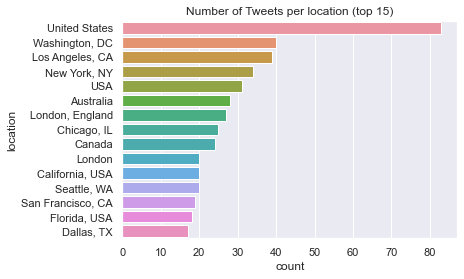

In [113]:
# location
sns.countplot(y="location", data=tweets_df, order=tweets_df.location.value_counts().iloc[:15].index).set_title('Number of Tweets per location (top 15)')

Principle summaries - work in progress

In [114]:
# number of followers retweets replies and likes

# tweets_df_stats = pd.melt(tweets_df, id_vars='id', value_vars=['no_followers', 'no_retweets', 'no_replies', 'no_likes'], var_name='type', value_name='value')

# fig = px.histogram(tweets_df_stats, 
#                     x="value", 
#                     color="type", 
#                     marginal="rug", # box violin
#                     hover_data=tweets_df_stats.columns)
# fig.show()

Correlations

<AxesSubplot:>

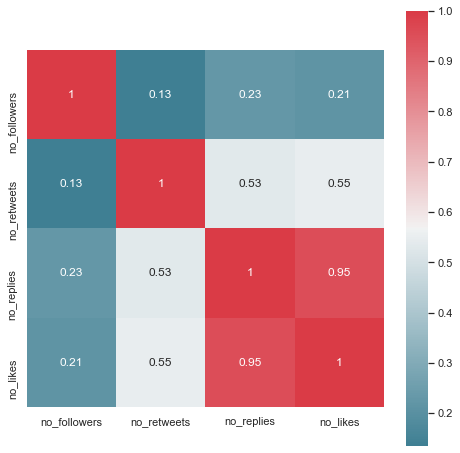

In [115]:
columns_show=['no_followers', 'no_retweets', 'no_replies', 'no_likes']
f, ax = plt.subplots(figsize=(8, 8))
corr = tweets_df[columns_show].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax,annot=True)

#### Text pre-processing

In [116]:
# List of punctations to be removed (# and @ might be reconsidered)
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [117]:
# Setting up stopwords list
stopwords = set(STOPWORDS)
# excluding keywords used in query (collection words)
stopwords.update(['covid', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine', 'vaccinated', 'vaccination', 'lockdown', 'quarantine'])
# excluding a couple more irrelevant ones
stopwords.update(['', 'u', 's', 'm', 've', 't', 'don', 're', 'amp'])

In [118]:
df = tweets_df[['text']]
df.head()

text
0  covid still exists and yall are so so close to...
1  School districts plan for the most UNFEASABLE ...
2  COVID-19 Omnibus (Emergency Measures) Bill 202...
3  From the archives: Coming together when we’re ...
4  YO Korean government has succeeded in developi...

#### Emojis and emoticons

In [119]:
# Function for converting emoticons into word
# def convert_emoticons(text):
#     for emot in EMOTICONS:
#         text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
#     return text

# tweets_df['emojis'] = tweets_df['text'].apply(lambda x: extract_emojis(x))
df['text_emoji'] = df['text'].apply(lambda x: emojis.decode(x))
# df['text_clean'] = df['text'].apply(lambda x: convert_emoticons(x))
df.head()

text  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   

                                          text_emoji  
0  covid still exists and yall are so so close to...  
1  School districts plan for the most UNFEASABLE ...  
2  COVID-19 Omnibus (Emergency Measures) Bill 202...  
3  From the archives: Coming together when we’re ...  
4  YO Korean government has succeeded in developi...

In [120]:
df['text'][0]

'covid still exists and yall are so so close to mark 😤😤😤😤😤😤😤'

In [121]:
df['text_emoji'][0]

'covid still exists and yall are so so close to mark :triumph::triumph::triumph::triumph::triumph::triumph::triumph:'

In [122]:
# Cleaning functions - 1st stage
def clean_text(text):
    # lowercase
    text_new = text.lower()
    
    # remove key-words
    key_words = ['covid', 'covid-19', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine', 'vaccines', 'vaccinated', 'vaccination', 'lockdown', 'quarantine', 'sars-cov-2']
    text_new  = ' '.join([word for word in text_new.split() if word not in key_words])
    
    # remove URL part
    text_new = text_new.replace("#", " #") # to keep hashtags occuring right after url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text_new = url_pattern.sub(r'', text_new)

    # remove new line sign 
    text_new = text_new.replace("\n", " ")
    text_new = " ".join(text_new.split())

    # remove punctation
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 
    text_new = text_new.translate(translator)
    text_new = re.sub('[0-9]+', '', text_new)

    return text_new

In [123]:
df['text_clean'] = df['text_emoji'].apply(lambda x: clean_text(x))
df.head(10)

text  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_emoji  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_clean  
0  still exists and yall are so so close to mark ...  
1  school districts plan for the most unfeasable ...  
2  omnibus  emergency measures  bill  introduced ...  
3  from the archives  coming together when we’re ...  
4  yo korean government has succeeded in developi...  
5  this is exactly the difference that every amer...  
6  cold plasma inactivates  medrxivpreprint  ucla...  
7  update  care packages for the ucsd th floor  n...  
8  i get they want to play  people want to watch ...  
9  my yr old s first test came back negative toda...

In [124]:
# Cleaning functions - 2nd stage
# Tokenization, stopwords, stemming or lemmatization 
def stem_lem_split(text, method='stem'):
    # tokenization
    tokens = re.split('\W+', text)

    # remove stopwords 
    text_s = [word for word in tokens if word not in stopwords]
    
    if method=='stem':
        # stemming
        ps = nltk.PorterStemmer()
        text_stem = [ps.stem(word) for word in text_s] 
        return text_stem

    elif method=='lem':
        # lemmatization
        wn = nltk.WordNetLemmatizer()
        text_lem = [wn.lemmatize(word) for word in text_s]
        return text_lem
    else:
        print('Invalid method')

In [125]:
df['text_stem'] = df['text_clean'].apply(lambda x: stem_lem_split(x, method='stem'))
df['text_lem'] = df['text_clean'].apply(lambda x: stem_lem_split(x, method='lem'))
df.head(10)

text  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_emoji  \
0  covid still exists and yall are so so close to...   
1  School districts plan for the most UNFEASABLE ...   
2  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  From the archives: Coming together when we’re ...   
4  YO Korean government has succeeded in developi...   
5  This is exactly the difference that every Amer...   
6  Cold plasma inactivates SARS-CoV-2 https://t.c...   
7  UPDATE: Care packages for the UCSD 10th floor ...   
8  I get they want to play.\nPeople want to watch...   
9  My 7yr old's first COVID test came back negati...   

                                          text_clean  \
0  still exists and yall are so so close to mark ...   
1  school districts plan for the most unfeasable ...   
2  omnibus  emergency measures  bill  introduced ...   
3  from the archives  coming together when we’re ...   
4  yo korean government has succeeded in developi...   
5  this is exactly the difference that every amer...   
6  cold plasma inactivates  medrxivpreprint  ucla...   
7  update  care packages for the ucsd th floor  n...   
8  i get they want to play  people want to watch ...   
9  my yr old s first test came back negative toda...   

                                           text_stem  \
0  [still, exist, yall, close, mark, triumph, tri...   
1  [school, district, plan, unfeas, safe, plan, o...   
2  [omnibu, emerg, measur, bill, introduc, releas...   
3                 [archiv, come, togeth, far, apart]   
4  [yo, korean, govern, succeed, develop, antibod...   
5  [exactli, differ, everi, american, think, vote...   
6  [cold, plasma, inactiv, medrxivpreprint, ucla,...   
7  [updat, care, packag, ucsd, th, floor, nurs, i...   
8  [want, play, peopl, want, watch, sport, done, ...   
9  [yr, old, first, test, came, back, neg, today,...   

                                            text_lem  
0  [still, exists, yall, close, mark, triumph, tr...  
1  [school, district, plan, unfeasable, safe, pla...  
2  [omnibus, emergency, measure, bill, introduced...  
3            [archive, coming, together, far, apart]  
4  [yo, korean, government, succeeded, developing...  
5  [exactly, difference, every, american, think, ...  
6  [cold, plasma, inactivates, medrxivpreprint, u...  
7  [update, care, package, ucsd, th, floor, nurse...  
8  [want, play, people, want, watch, sport, done,...  
9  [yr, old, first, test, came, back, negative, t...

#### Word Clouds


In [126]:
string_wc = pd.Series(df['text_clean']).str.cat(sep=' ')

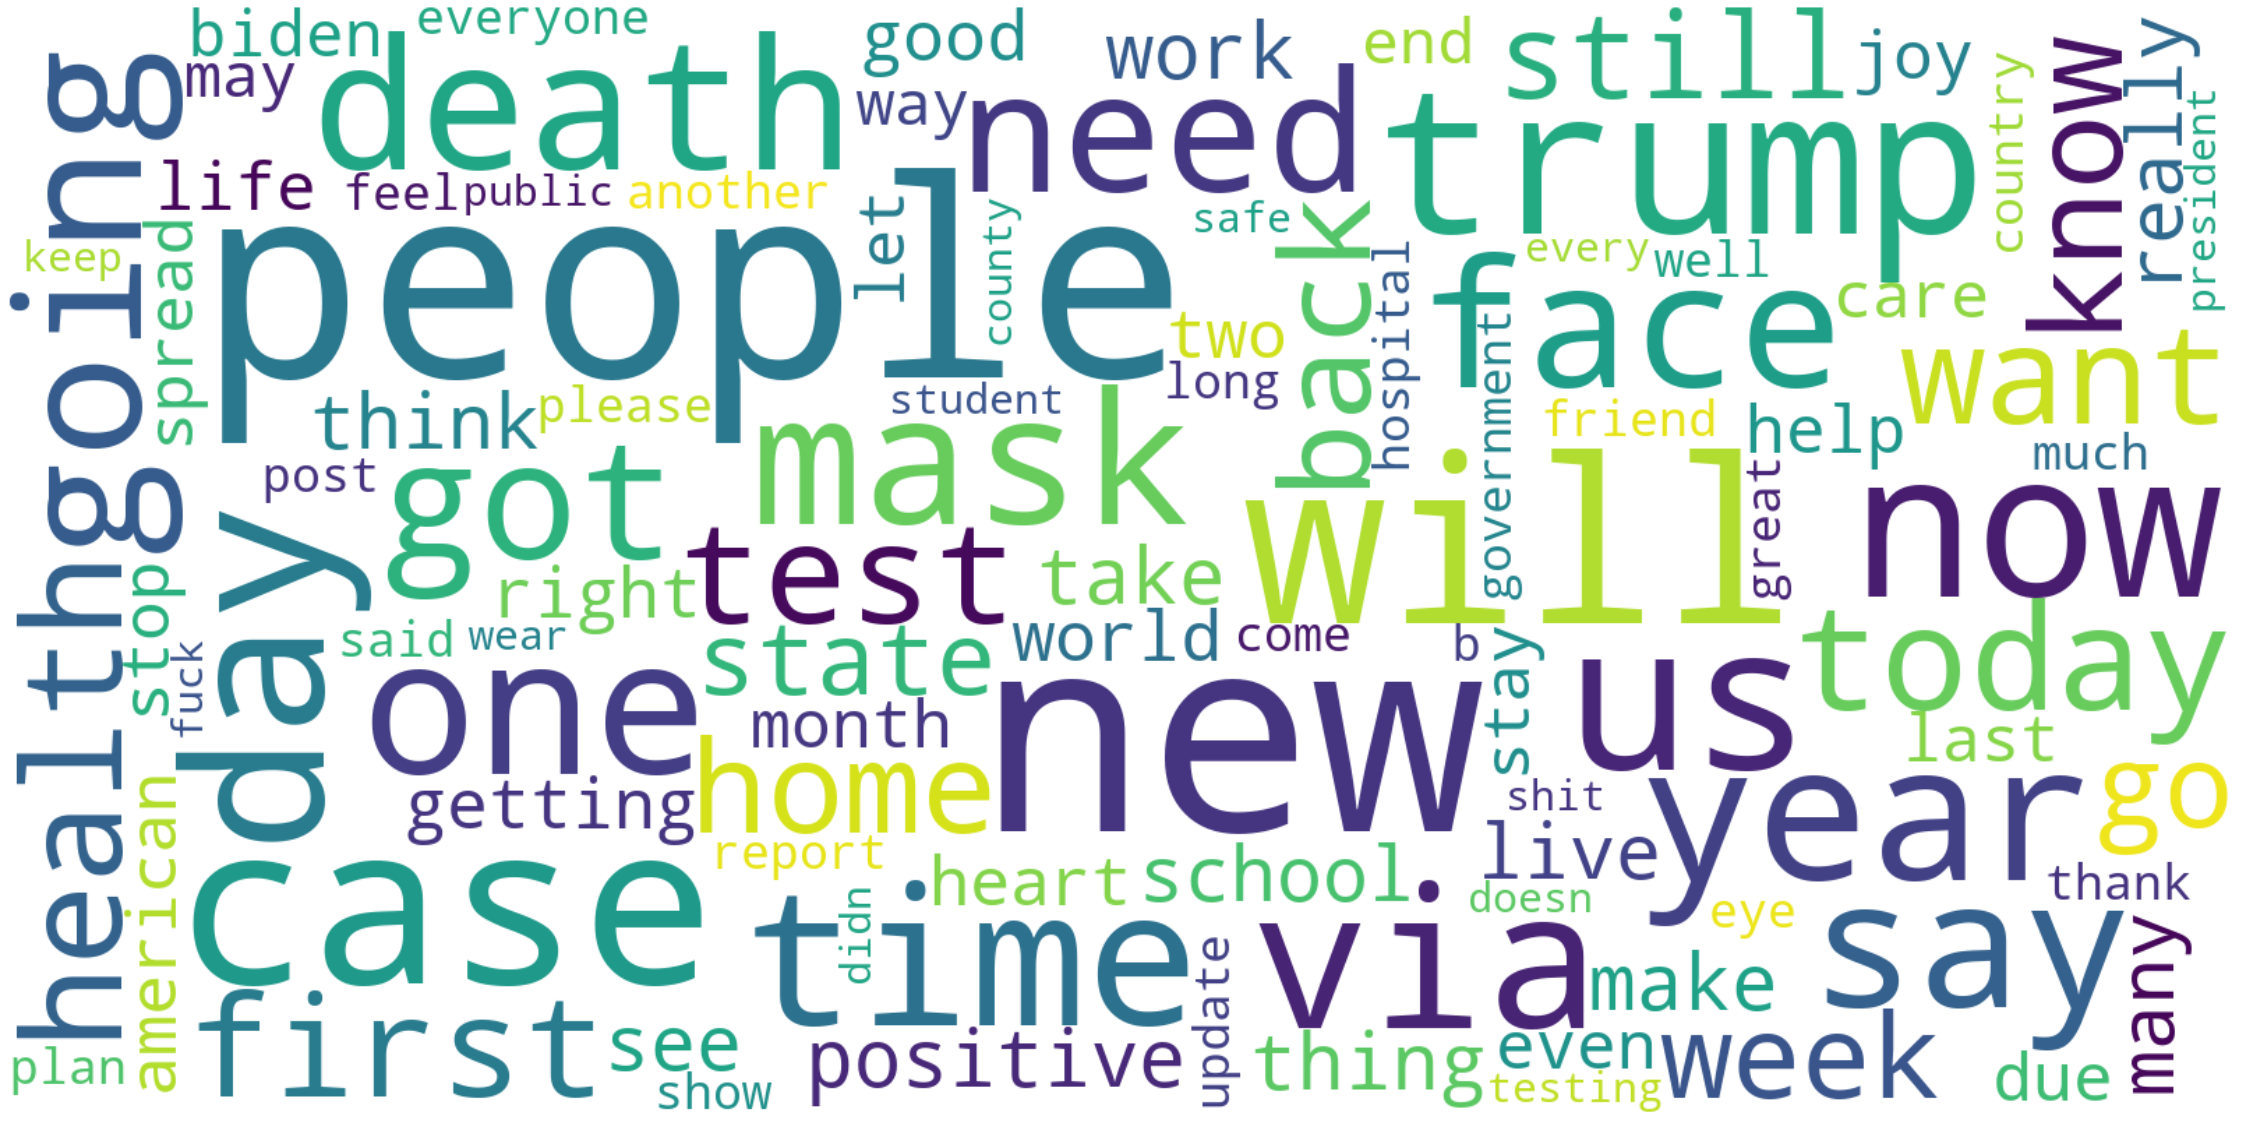

In [127]:
# Word Cloud before stemming/lemmatization
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_wc)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

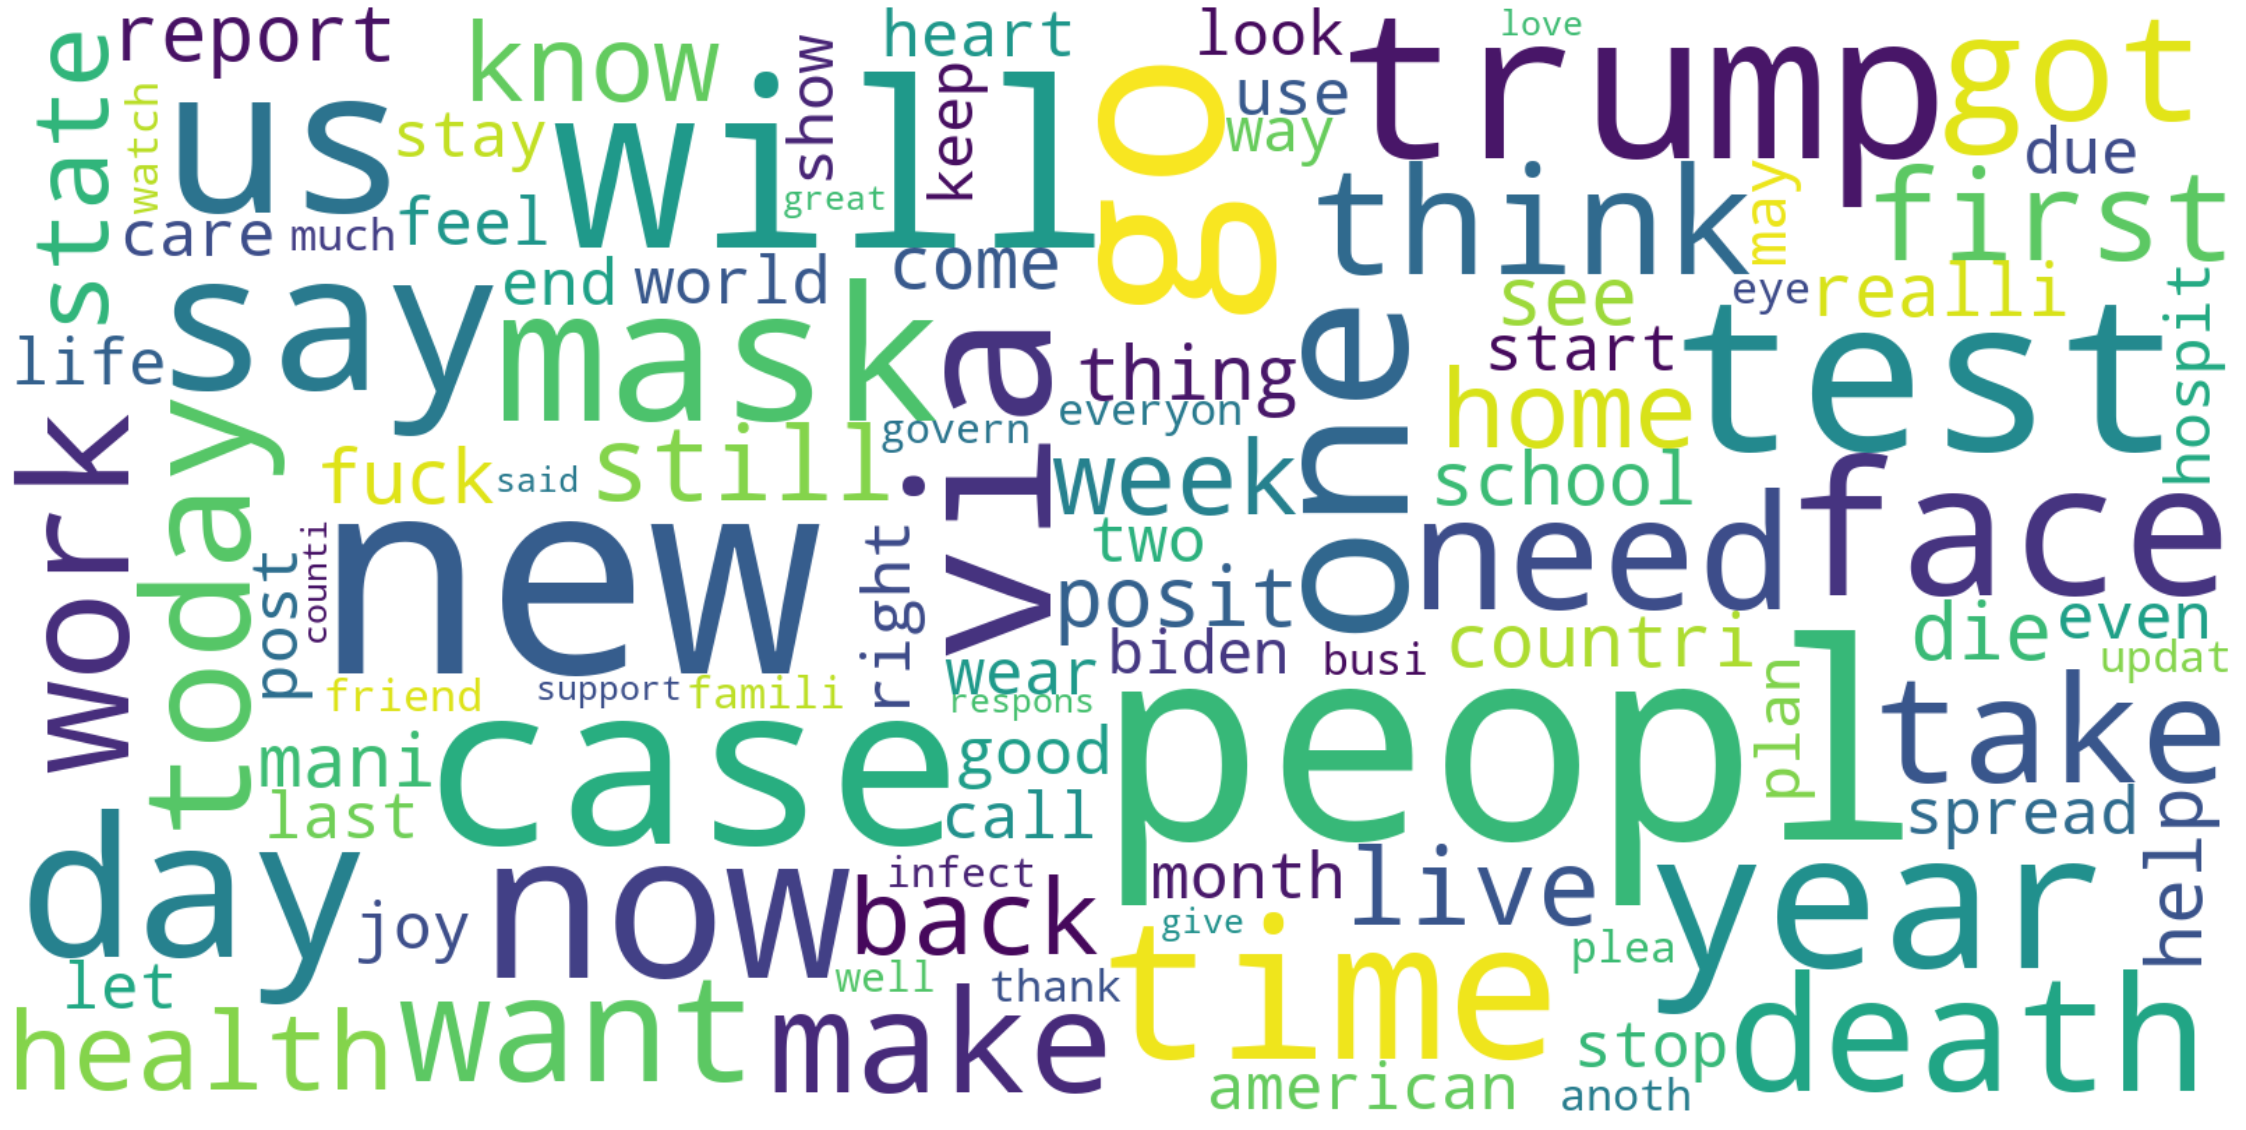

In [128]:
# Word Cloud after stemming
string_stem = df['text_stem'].apply(lambda x: " ".join(x))
string_stem = pd.Series(string_stem).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_stem)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

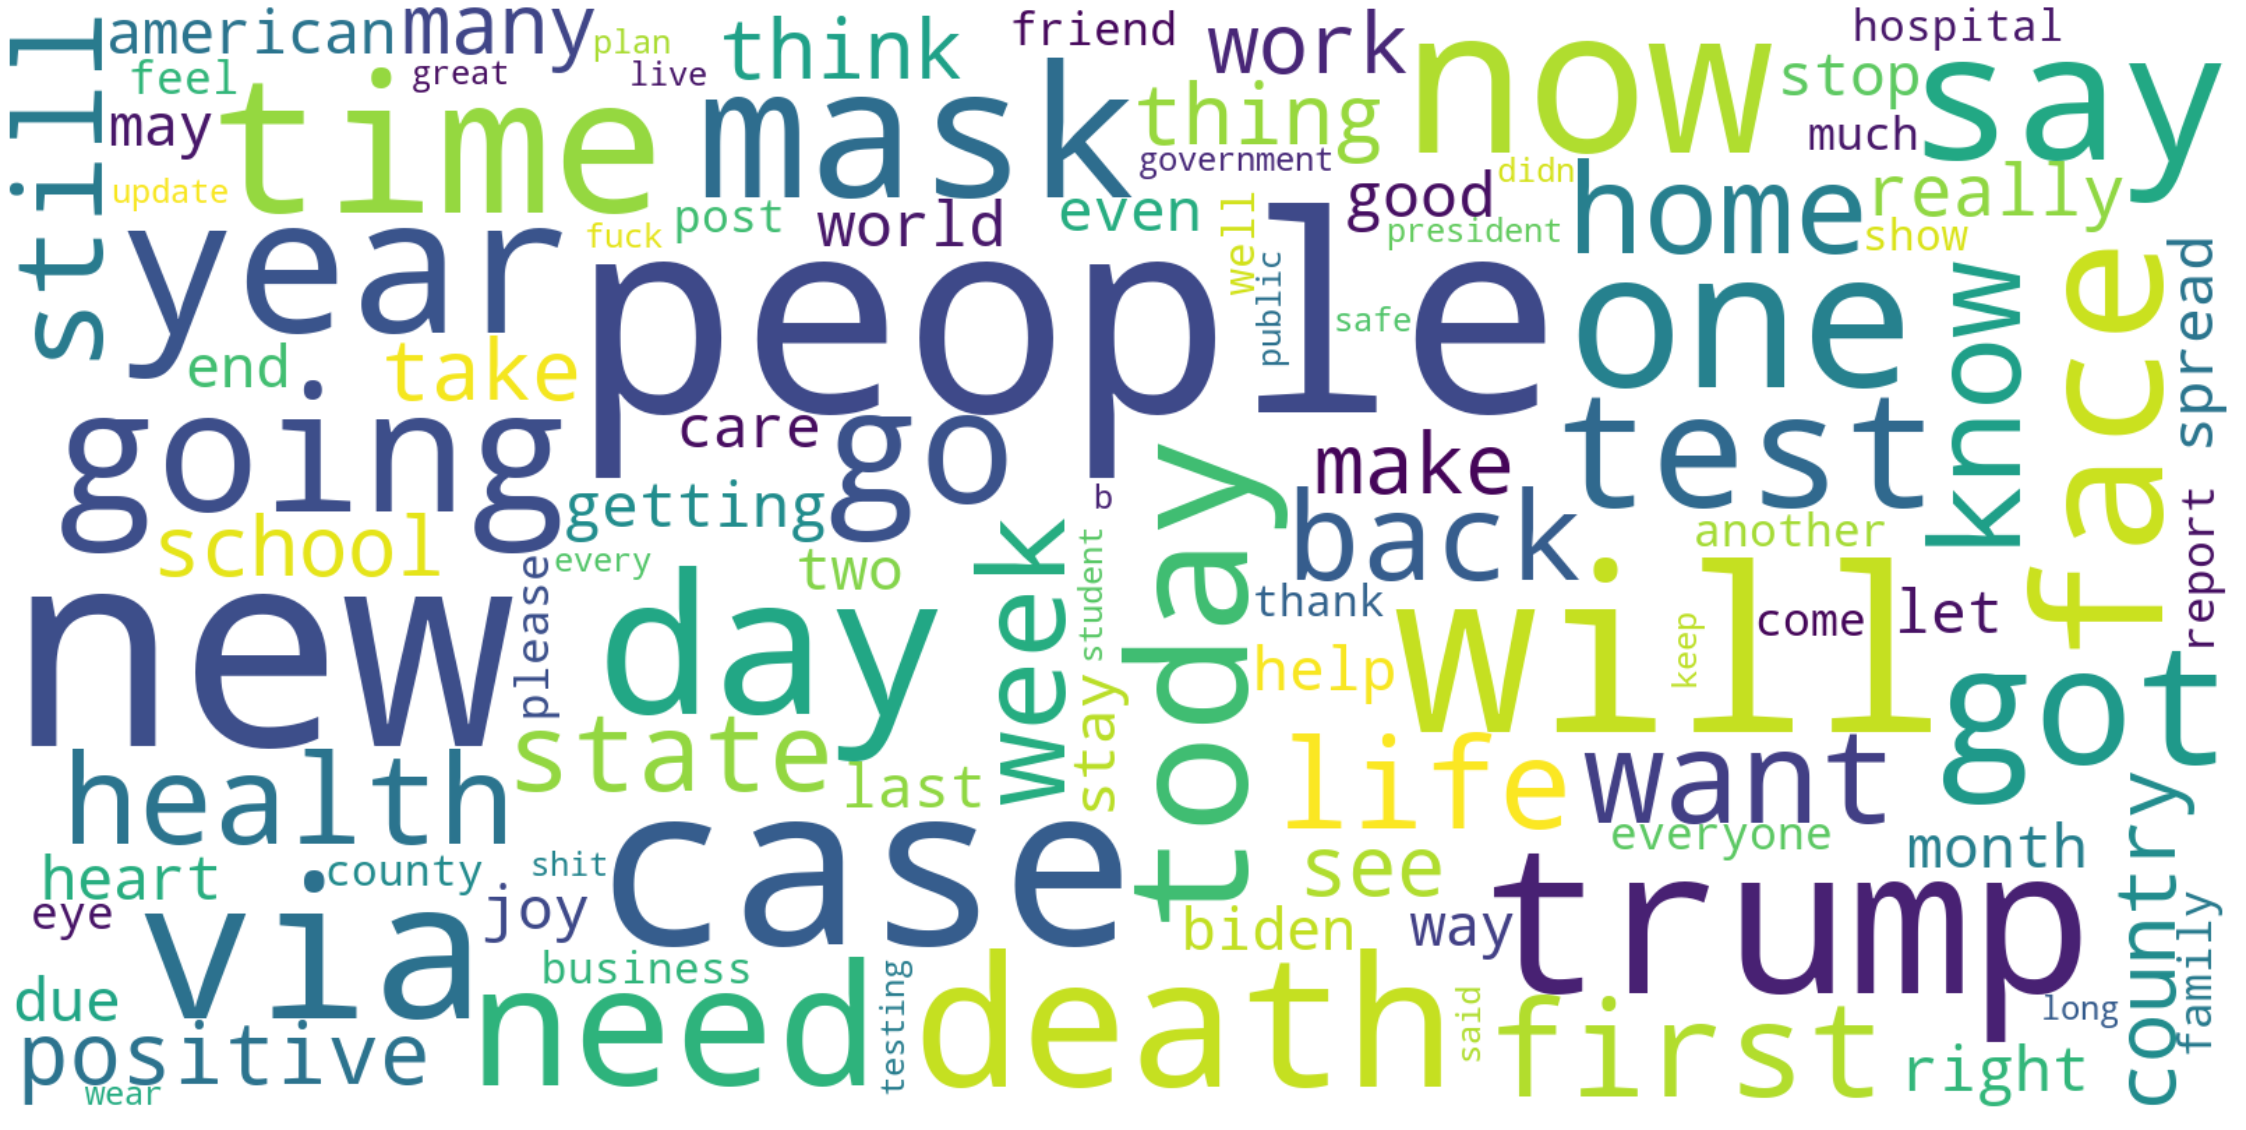

In [129]:
# Word Cloud after lemmatization
string_lem = df['text_lem'].apply(lambda x: " ".join(x))
string_lem = pd.Series(string_lem).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='white').generate_from_text(string_lem)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Bigrams and Trigrams

In [130]:
def create_ngram(tweets, n=2):
    if n==2:
        terms = [list(bigrams(tweet)) for tweet in tweets]
        colname = 'bigram'
    elif n==3:
        terms = [list(everygrams(tweet, 3, 3)) for tweet in tweets]
        colname = 'trigram'
    else: 
        print("Invalid n")
        return 0

    # Flatten list of bigrams in clean tweets
    ngrams = list(itertools.chain(*terms))
    # Create counter of words in clean bigrams
    ngram_counts = collections.Counter(ngrams)
    # DataFrame from the counter
    ngram_df = pd.DataFrame(ngram_counts.most_common(25),columns=[colname, 'count'])
    return ngram_df

In [144]:
bigram_df = create_ngram(df['text_stem'], n=2)
trigram_df = create_ngram(df['text_stem'], n=3)

Text(0.5, 1.0, '25 most frequent bigrams - stemmed')

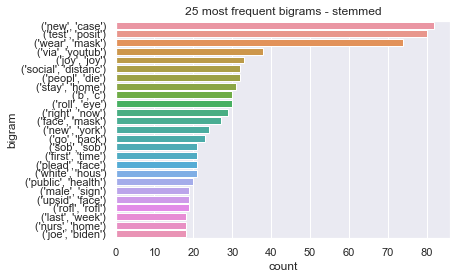

In [145]:
sns.barplot(x=bigram_df['count'], y=bigram_df['bigram']).set_title('25 most frequent bigrams - stemmed')

Text(0.5, 1.0, '25 most frequent trigrams - stemmed')

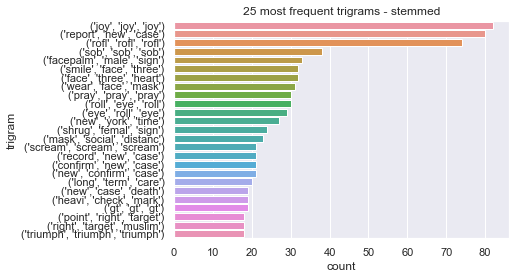

In [146]:
sns.barplot(x=bigram_df['count'], y=trigram_df['trigram']).set_title('25 most frequent trigrams - stemmed')

#### Text Networks - work in progress

Stemmed text

In [147]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

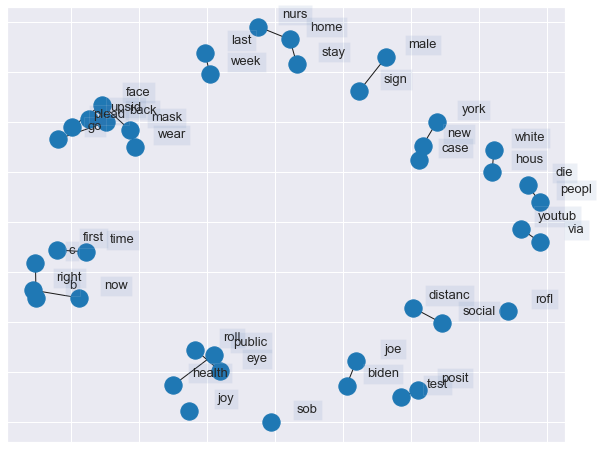

In [148]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(alpha=0.1),
            horizontalalignment='center', fontsize=13)
    
plt.show()

Lemmatized text

In [149]:
bigram_df = create_ngram(df['text_lem'], n=2)

In [150]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

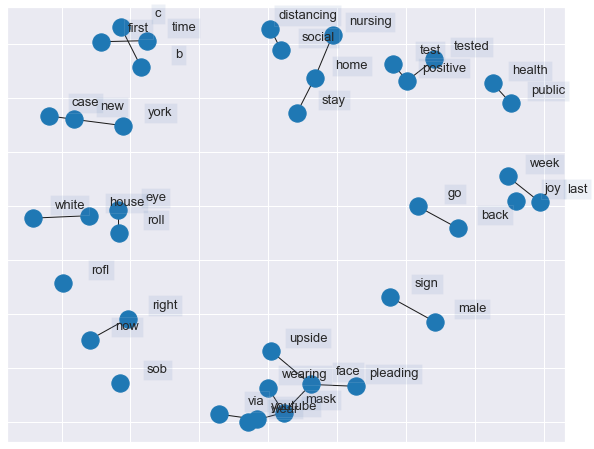

In [151]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(alpha=0.1),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 5. Saving the output file

In [136]:
# Adding cleaned text to initial twitter df
tweets_df['text_clean'] = df['text_clean']
tweets_df['text_stem'] = df['text_stem']
tweets_df['text_lem'] = df['text_lem']
tweets_df.head()

id                                               text  \
0  1356028686701477888  covid still exists and yall are so so close to...   
1  1293697993875623936  School districts plan for the most UNFEASABLE ...   
2  1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  1378858911747411968  From the archives: Coming together when we’re ...   
4  1237528569640698112  YO Korean government has succeeded in developi...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2021-01-31 23:56:47+00:00           0            0         0   
1  2020-08-12 23:56:52+00:00           0            0         0   
2  2020-04-22 23:58:34+00:00           0            0         0   
3  2021-04-04 23:55:57+00:00           0            0         1   
4  2020-03-10 23:59:37+00:00           1            5         3   

                                 user                   location  \
0                              diji 🎀                  Mark Tuan   
1  @Pechilvr @WarOnFibro #OwnYourData             North Carolina   
2                        Sean Mulcahy  Ballarat North, Australia   
3                Mum Muddling Through              Kent, England   
4                         miracassano                        NaN   

   no_followers sentiment                                         text_clean  \
0            43  negative  still exists and yall are so so close to mark ...   
1           935   neutral  school districts plan for the most unfeasable ...   
2          1828   neutral  omnibus  emergency measures  bill  introduced ...   
3         14712  positive  from the archives  coming together when we’re ...   
4          1231  positive  yo korean government has succeeded in developi...   

                                           text_stem  \
0  [still, exist, yall, close, mark, triumph, tri...   
1  [school, district, plan, unfeas, safe, plan, o...   
2  [omnibu, emerg, measur, bill, introduc, releas...   
3                 [archiv, come, togeth, far, apart]   
4  [yo, korean, govern, succeed, develop, antibod...   

                                            text_lem  
0  [still, exists, yall, close, mark, triumph, tr...  
1  [school, district, plan, unfeasable, safe, pla...  
2  [omnibus, emergency, measure, bill, introduced...  
3            [archive, coming, together, far, apart]  
4  [yo, korean, government, succeeded, developing...

In [137]:
tweets_df.to_pickle('../data/covid19_tweets_cleaned_5000.pkl')

In [138]:
# tweets_df.to_csv('../data/covid19_tweets_cleaned.csv', index=False)